In [20]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import tensorflow as tf
import keras

# Display
from IPython.display import Image, display
import matplotlib as mpl
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array
from PIL import Image
import os
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.regularizers import l2
import random
import pandas as pd
import tensorflow as tf
import argparse
import keras_cv_attention_models
import glob


In [21]:
#model hyper parameters:
image_size = 150 
batch_size =100 
learning_rate = 0.001 
image_count_thr = 20 
opt ='Adam'
seed=42
modell = "MobileViT_S" 
visit = "0912" 
cv = "cv1" 
cv_rate = 0.8

In [22]:

os.chdir("/home/yebi/ComputerVision_PLF/Pig_BW/Pig_BW_DL_beta/DL/")
df1 = pd.read_csv("./labelled_depth_0718.csv", dtype={'Visit': str})
df2 = pd.read_csv("./labelled_depth_0801.csv", dtype={'Visit': str})
df3 = pd.read_csv("./labelled_depth_0815.csv", dtype={'Visit': str})
df4 = pd.read_csv("./labelled_depth_0829.csv", dtype={'Visit': str})
df5 = pd.read_csv("./labelled_depth_0912.csv", dtype={'Visit': str})
df6 = pd.read_csv("./labelled_depth_0927.csv", dtype={'Visit': str})

# # labelled_depth = pd.concat([df1, df2, df3], axis=0)
if cv == 'cv1':
    if visit == "0718":
        labelled_depth = df1
    elif visit == "0801":
        labelled_depth = df2
    elif visit == "0815":
        labelled_depth = df3
    elif visit == "0829":
        labelled_depth = df4
    elif visit == "0912":
        labelled_depth = df5
    elif visit == "0927":
        labelled_depth = df6
   
if cv == "cv2" or cv == 'cv2_0':
    if visit == "0801":
        labelled_depth = pd.concat([df1, df2], axis=0)
    elif visit == "0815":
        labelled_depth = pd.concat([df1, df2, df3], axis=0)
    elif visit == "0829":
        labelled_depth = pd.concat([df1, df2, df3, df4], axis=0)
    elif visit == "0912":
        labelled_depth = pd.concat([df1, df2, df3, df4, df5], axis=0)
    elif visit == "0927":
        labelled_depth = pd.concat([df1, df2, df3, df4, df5, df6], axis=0)

######################################################################
## Remove outliers in ground truth body weights.
weight_percentile = 3
weight_threshold = labelled_depth["Weights"].quantile(weight_percentile / 100)
labelled_depth = labelled_depth[labelled_depth["Weights"] >= weight_threshold]
print(f"Remove weight outliers by {weight_percentile}% quantile")


######################################################################
# Count the occurrences of each category
category_counts = labelled_depth['Bag_ID'].value_counts()
# Select rows based on the frequency condition
selected_rows = pd.DataFrame()
for category, count in category_counts.items():
    category_data = labelled_depth[labelled_depth['Bag_ID'] == category]
    if count <= image_count_thr:
        selected_rows = pd.concat([selected_rows, category_data])
    else:
        interval = count // image_count_thr
        selected_indices = np.arange(0, count, interval)[:image_count_thr]
        selected_rows = pd.concat([selected_rows, category_data.iloc[selected_indices]])
labelled_depth = selected_rows
print("Total images are ", labelled_depth.shape[0])

######################################################################

def read_images(labelled_depth, image_size):
    images = []
    img_paths = []
    for filename in labelled_depth["FilePath"]:
        if filename.endswith('.png'):  
            if os.path.exists(filename):
                img_path = filename
                img = tf.io.read_file(img_path)
                img = tf.image.decode_png(img, channels=3)  
                img = tf.image.resize_with_crop_or_pad(img, target_height=int(img.shape[1]), target_width=int(img.shape[1]))
                img = tf.image.resize(img, [image_size, image_size]) #Resize images
                images.append(img)
                img_paths.append(img_path)

    processed_images = tf.stack(images)
    processed_images = tf.cast(processed_images, tf.float32)
    processed_images /= 255.0
    print("DDDDDDDDDDDDDDDDDDDDDDDD")
    return processed_images, img_paths
######################################################################

if cv == "cv1":
    import random
    random.seed(seed)
    pig_n = np.unique(labelled_depth['Bag_ID']).shape[0]
    train_bag_id = random.sample(list(np.unique(labelled_depth["Bag_ID"])), int(pig_n*0.8))
    train_df = labelled_depth[labelled_depth["Bag_ID"].isin(train_bag_id)]
    test_df = labelled_depth[-labelled_depth["Bag_ID"].isin(train_bag_id)]

elif cv == 'cv2':
    cv_name = "CrossValidation" + str(cv_rate)
    train_df = labelled_depth[labelled_depth[cv_name] == "train"]
    test_df = labelled_depth[(labelled_depth[cv_name] == "test") & (labelled_depth["Visit"] == visit)]

elif cv == 'cv2_0':
    cv_name = "CrossValidation" + str(cv_rate)
    train_df = labelled_depth[
        (labelled_depth[cv_name] == "train") | 
        ((labelled_depth[cv_name] == "test") & (labelled_depth["Visit"] != visit))
        ]
    test_df = labelled_depth[(labelled_depth[cv_name] == "test") & (labelled_depth["Visit"] == visit)]


Remove weight outliers by 3% quantile
Total images are  6570


In [23]:
print("Now is reading testing sets")
x_test, test_img_path = read_images(labelled_depth=test_df, image_size = image_size)
print("x_test shape is: ", x_test.shape, len(test_img_path))
y_test = test_df["Weights"].values
y_test = y_test.astype(np.float32)
print("y_test shape is: ", y_test.shape)

Now is reading testing sets
DDDDDDDDDDDDDDDDDDDDDDDD
x_test shape is:  (1310, 150, 150, 3) 1310
y_test shape is:  (1310,)


In [24]:

    def keras_cv_attention_model(modell):           
        if modell == "MobileViT_XXS":
            base_model = keras_cv_attention_models.mobilevit.MobileViT_XXS(pretrained='imagenet', num_classes=0, input_shape=(image_size, image_size, 3))
        elif modell == "MobileViT_S":
            base_model = keras_cv_attention_models.mobilevit.MobileViT_S(pretrained='imagenet', num_classes=0, input_shape=(image_size, image_size, 3))
        elif modell == "MobileViT_V2_050":
            base_model = keras_cv_attention_models.mobilevit.MobileViT_V2_050(pretrained='imagenet', num_classes=0, input_shape=(image_size, image_size, 3))
        elif modell == "MobileViT_V2_100":
            base_model = keras_cv_attention_models.mobilevit.MobileViT_V2_100(pretrained='imagenet', num_classes=0, input_shape=(image_size, image_size, 3))
        elif modell == "MobileViT_V2_150":
            base_model = keras_cv_attention_models.mobilevit.MobileViT_V2_150(pretrained='imagenet', num_classes=0, input_shape=(image_size, image_size, 3))
        elif modell == "MobileViT_V2_200":
            base_model = keras_cv_attention_models.mobilevit.MobileViT_V2_200(pretrained='imagenet', num_classes=0, input_shape=(image_size, image_size, 3))
        elif modell == "MobileNetV3Small050":
            base_model = keras_cv_attention_models.mobilenetv3_family.mobilenetv3.MobileNetV3Small050(pretrained='imagenet', num_classes=0, input_shape=(image_size, image_size, 3))
        elif modell == "MobileNetV3Large075":
            base_model = keras_cv_attention_models.mobilenetv3_family.mobilenetv3.MobileNetV3Large075(pretrained='imagenet', num_classes=0, input_shape=(image_size, image_size, 3))
        elif modell == "MobileNetV3Large100":
            base_model = keras_cv_attention_models.mobilenetv3_family.mobilenetv3.MobileNetV3Large100(pretrained='imagenet', num_classes=0, input_shape=(image_size, image_size, 3))
        else:
            raise ValueError(f"Model {modell} not recognized in keras_cv_attention_model function")

        return base_model

    
    ############################
    def keras_model(modell):
        if modell == "ResNet50":
            base_model = keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
        elif modell == "MobileNet050":
            base_model = keras.applications.MobileNet(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3), alpha=0.5)
        elif modell == "MobileNet100":
            base_model = keras.applications.MobileNet(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3), alpha=1.0) 
        elif modell == "MobileNet075":
            base_model = keras.applications.MobileNet(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3), alpha=0.75)   
        else:
            raise ValueError(f"Model {modell} not recognized in keras_model function")
        
        # Freeze the base model layers
        for layer in base_model.layers:
            layer.trainable = trainable

        return base_model


    ############################    
    def load_bw_model(model):
        try:
            return keras_cv_attention_model(model)
        except ValueError:
            return keras_model(model)
    ############################


In [25]:
from keras.models import Model
from keras.layers import Input, Flatten, Dropout, Dense
from keras.regularizers import l2

base_model = load_bw_model(model=modell)
x = Flatten()(base_model.output)
x = Dropout(0.5)(x)
output_layer = Dense(1, activation='linear', kernel_regularizer=l2(0.001))(x)
model = Model(inputs=base_model.input, outputs=output_layer)

>>>> Load pretrained from: /home/yebi/.keras/models/mobilevit_s_imagenet.h5


In [26]:
# # Learning rate scheduler to reduce the learning rate when validation loss plateaus
# reduce_lr_callback = keras.callbacks.ReduceLROnPlateau(
# monitor='val_loss',
# factor=0.1,
# patience=epochs//4,
# min_lr=1e-6
# )

# import pickle
# # Initialize an empty dictionary to store training history
# training_history = {'loss': [], 'mean_squared_error': [], 'val_loss': [], 'val_mean_squared_error': []}   

# Compile the model with a mean squared error loss and an Adam optimizer

# for layer in model.layers[:-3/]:
#     layer.trainable = False
    
# if visit == "0801": 
#     checkpoint_filepath='/home/yebi/ComputerVision_PLF/Pig_BW/Run/BestModelCV1/T2/checkpoint_MobileViT_S_visit_0801_image_size_150_trainable_True_batch_size_100_epochs_300_lr_0.001_seed_42_opt_Adam_image_count_thr_20'
# elif visit == '0815':
#     checkpoint_filepath='/home/yebi/ComputerVision_PLF/Pig_BW/Run/BestModelCV1/T3/checkpoint_MobileViT_S_visit_0815_image_size_150_trainable_True_batch_size_100_epochs_300_lr_0.001_seed_42_opt_Adam_image_count_thr_20'
if visit == '0829':
    checkpoint_filepath='/home/yebi/ComputerVision_PLF/Pig_BW/Run/BestModelCV1/T4/checkpoint_MobileViT_S_cv1_0.8_visit_0829_image_size_150_trainable_True_batch_size_100_epochs_300_lr_0.001_seed_42_opt_Adam_image_count_thr_20.h5'
else:
    checkpoint_filepath = '/home/yebi/ComputerVision_PLF/Pig_BW/Run/BestModelCV1/T5_Model/checkpoint_MobileViT_S_cv1_0.8_visit_0912_image_size_150_trainable_True_batch_size_100_epochs_300_lr_0.001_seed_42_opt_Adam_image_count_thr_20.h5'
    # checkpoint_filepath='/home/yebi/ComputerVision_PLF/Pig_BW/Run/BestModelCV1/T5/checkpoint_MobileViT_S_cv1_0.8_visit_0912_image_size_150_trainable_True_batch_size_100_epochs_300_lr_0.001_seed_42_opt_Adam_image_count_thr_20'
# elif visit == '0927':
#     checkpoint_filepath='/home/yebi/ComputerVision_PLF/Pig_BW/Run/BestModelCV2/T6/checkpoint_MobileViT_S_cv2_0.75_visit_0927_image_size_150_trainable_True_batch_size_100_epochs_300_lr_0.001_seed_42_opt_Adam_image_count_thr_20'


model.load_weights(checkpoint_filepath)
# 
if opt == "Adam":
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate, epsilon=1e-05)

model.compile(optimizer=optimizer, 
            loss=keras.losses.MeanSquaredError(), 
            metrics=[keras.losses.MeanSquaredError()])

In [27]:
np.squeeze(model.predict(x_test[1:10]))

1/1 [==============================] - 2s 2s/step


array([129.35777, 128.8455 , 128.6799 , 130.75021, 130.28679, 129.42389,
       130.4055 , 129.91435, 132.00609], dtype=float32)

In [28]:
predicted_weight = np.squeeze(model.predict(x_test))
true_weight = y_test

41/41 [==============================] - 1s 26ms/step


In [29]:
# predicted_weights_sequential = pd.read_csv('/home/yebi/ComputerVision_PLF/Pig_BW/Run/BestModelCV1/T5/weights_comparison.csv', dtype={'Visit': str})
# predicted_weights_sequential[]

In [30]:
# labelss = (predicted_weights_sequential["predicted_Weights"] - predicted_weights_sequential["true_Weights"]).values
# labelss

In [31]:

# def get_img_array(img_path, size):
#     # `img` is a PIL image of size 299x299
#     img = keras.utils.load_img(img_path, target_size=size)
#     # `array` is a float32 Numpy array of shape (299, 299, 3)
#     array = keras.utils.img_to_array(img)
#     # We add a dimension to transform our array into a "batch"
#     # of size (1, 299, 299, 3)
#     array = np.expand_dims(array, axis=0)
#     return array
    


import tensorflow as tf
from tensorflow import keras
import numpy as np


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, output_index=0):
    # Create a model that maps the input image to the activations of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Compute the gradient of the output neuron (linear regression) with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        class_channel = preds[:, output_index]

    # Get the gradients of the output w.r.t the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # Compute the mean intensity of the gradient over the feature map channels
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply each channel in the feature map array by the importance of this channel
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Example usage
# Assuming `model` is your trained Keras model and `img_array` is a preprocessed image ready for the model
# last_conv_layer_name is the name of the last convolutional layer in your model
# heatmap = make_gradcam_heatmap(img_array, model, "last_conv_layer_name")



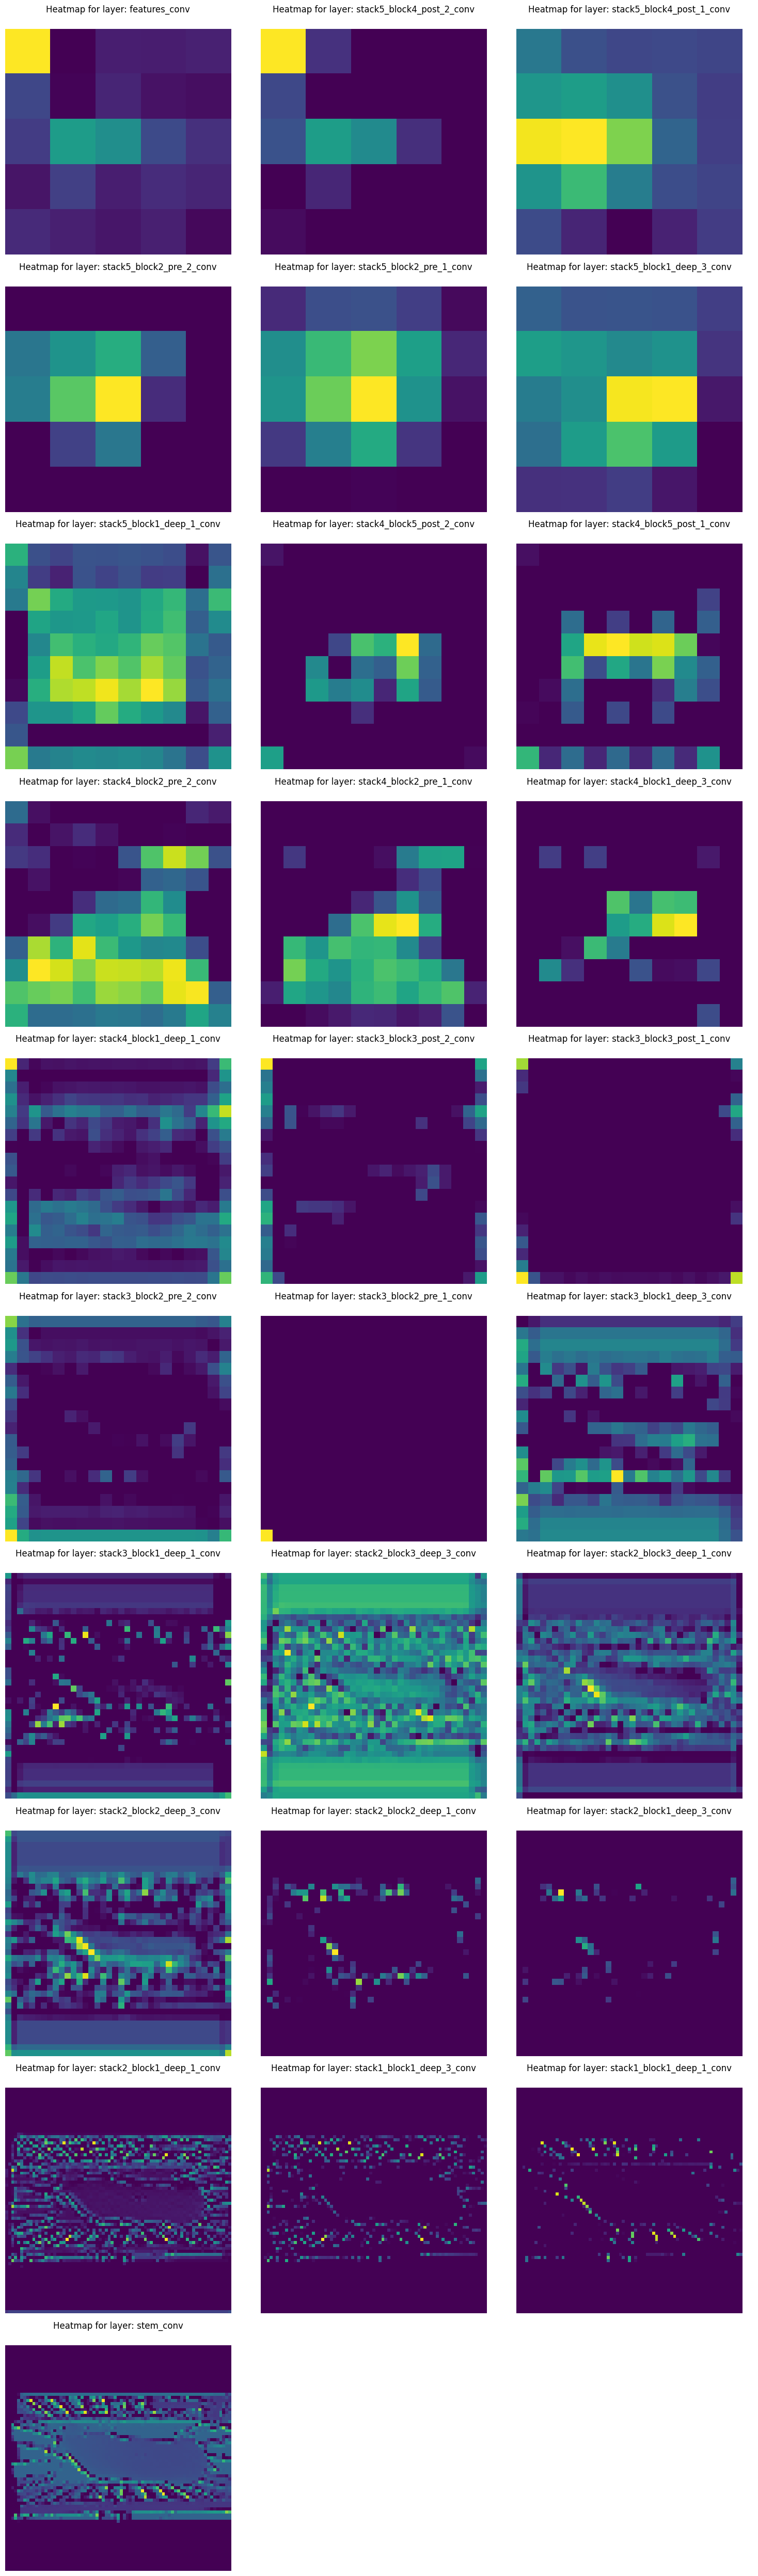

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras

layer_names = []

# Collect the names of all Conv2D layers in reverse order
for layer in reversed(model.layers):
    if isinstance(layer, keras.layers.Conv2D):
        layer_names.append(layer.name)

# Number of Conv2D layers
num_layers = len(layer_names)

# Number of columns per row
cols = 3
# Calculate number of rows needed
rows = (num_layers + cols - 1) // cols

# Create subplots with the determined number of rows and columns
fig, axs = plt.subplots(rows, cols, figsize=(15, 5 * rows))

# Plot heatmap for each Conv2D layer
rr = 200
img_path0 = test_img_path[rr]
img_array = np.expand_dims(x_test[rr], axis=0)

for idx, layer_name in enumerate(layer_names):
    heatmap = make_gradcam_heatmap(img_array, model, layer_name)
    
    # Determine the position in the subplot grid
    row = idx // cols
    col = idx % cols

    # Display heatmap in the respective subplot
    axs[row, col].matshow(heatmap)
    axs[row, col].set_title(f'Heatmap for layer: {layer_name}')
    axs[row, col].axis('off')

# Hide any unused subplots
for idx in range(num_layers, rows * cols):
    row = idx // cols
    col = idx % cols
    axs[row, col].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
# rr = np.argmax(y_test)
for rr in range(0, 100, 20):
    img_path0 = test_img_path[rr]
    img_array = np.expand_dims(x_test[rr], axis=0)
    heatmap = make_gradcam_heatmap(img_array, model, 'stack5_block2_pre_2_conv')

    # # Display heatmap
    plt.matshow(heatmap)
    plt.show()

In [34]:
len(predicted_weight)

1310

In [35]:
len(set(y_test))

55

In [36]:
mpl.colormaps()

['magma',
 'inferno',
 'plasma',
 'viridis',
 'cividis',
 'twilight',
 'twilight_shifted',
 'turbo',
 'Blues',
 'BrBG',
 'BuGn',
 'BuPu',
 'CMRmap',
 'GnBu',
 'Greens',
 'Greys',
 'OrRd',
 'Oranges',
 'PRGn',
 'PiYG',
 'PuBu',
 'PuBuGn',
 'PuOr',
 'PuRd',
 'Purples',
 'RdBu',
 'RdGy',
 'RdPu',
 'RdYlBu',
 'RdYlGn',
 'Reds',
 'Spectral',
 'Wistia',
 'YlGn',
 'YlGnBu',
 'YlOrBr',
 'YlOrRd',
 'afmhot',
 'autumn',
 'binary',
 'bone',
 'brg',
 'bwr',
 'cool',
 'coolwarm',
 'copper',
 'cubehelix',
 'flag',
 'gist_earth',
 'gist_gray',
 'gist_heat',
 'gist_ncar',
 'gist_rainbow',
 'gist_stern',
 'gist_yarg',
 'gnuplot',
 'gnuplot2',
 'gray',
 'hot',
 'hsv',
 'jet',
 'nipy_spectral',
 'ocean',
 'pink',
 'prism',
 'rainbow',
 'seismic',
 'spring',
 'summer',
 'terrain',
 'winter',
 'Accent',
 'Dark2',
 'Paired',
 'Pastel1',
 'Pastel2',
 'Set1',
 'Set2',
 'Set3',
 'tab10',
 'tab20',
 'tab20b',
 'tab20c',
 'grey',
 'gist_grey',
 'gist_yerg',
 'Grays',
 'magma_r',
 'inferno_r',
 'plasma_r',
 'viri

In [79]:
from IPython.display import Image, display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras

def process_gradcam(img_path11, heatmap, alpha=1):
    # Load the original image
    img = keras.utils.load_img(img_path11)
    img = tf.convert_to_tensor(img)
    img = tf.image.resize_with_crop_or_pad(img, target_height=int(img.shape[1]), target_width=int(img.shape[1]))
    img = tf.image.resize(img, [image_size, image_size]) #Resize images
    img = keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use inferno colormap to colorize heatmap
    inferno = mpl.colormaps["viridis"]
    inferno_colors = inferno(np.arange(256))[:, :3]
    inferno_heatmap = inferno_colors[heatmap]

    # Create an image with RGB colorized heatmap
    inferno_heatmap = keras.utils.array_to_img(inferno_heatmap)
    inferno_heatmap = inferno_heatmap.resize((img.shape[1], img.shape[0]))
    inferno_heatmap = keras.utils.img_to_array(inferno_heatmap)

    # Superimpose the heatmap on the original image
    superimposed_img = inferno_heatmap * alpha + img*0.2
    return keras.utils.array_to_img(superimposed_img)


def display_gradcam_grid(img_paths, heatmaps, labels, groud_bw, rrr, grid_size=(5, 5)):
    num_rows, num_cols = grid_size
    # Adjust the figure size based on the number of rows and columns
    fig_size = (num_cols * 3, num_rows * 3)  # 3 is a scaling factor, adjust as necessary
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=fig_size)
    axes = axes.flatten()
    
    for ax, img_path, heatmap, label, y, r in zip(axes, img_paths, heatmaps, labels, groud_bw, rrr):
        img_with_heatmap = process_gradcam(img_path, heatmap)
        ax.imshow(img_with_heatmap)
        ax.set_title(f"Measurement Error: {label:.2f} kg\nScale-BW: {y:.2f} kg\n #index: {r}")
        # ax.set_title(f"Measurement Error: {label:.2f} kg\nScale-BW: {y:.2f} kg")
        ax.axis('off')

    plt.tight_layout()
    # plt.savefig("./DrawingPlots/grad_cam.pdf", format='pdf')
    plt.show()


In [38]:
set(y_test)

{86.636,
 88.451,
 89.811,
 98.883,
 99.337,
 99.79,
 100.244,
 101.605,
 102.058,
 102.512,
 103.419,
 103.873,
 104.326,
 106.141,
 106.594,
 107.501,
 107.955,
 109.316,
 109.996,
 111.992,
 112.037,
 113.398,
 113.852,
 114.305,
 114.759,
 115.212,
 116.12,
 117.934,
 118.388,
 118.841,
 118.977,
 119.295,
 119.748,
 121.109,
 121.563,
 122.47,
 122.924,
 122.969,
 123.377,
 123.831,
 125.191,
 125.645,
 127.459,
 127.913,
 127.958,
 128.82,
 130.997,
 131.542,
 131.995,
 132.449,
 132.903,
 135.171,
 135.987,
 136.531,
 136.985}

In [52]:
df_cv = pd.DataFrame({
    'Actual Weight': y_test,
    'Predicted Weight': predicted_weight,
    'ME': predicted_weight - y_test
})

# Calculate the absolute mean error (ME)
df_cv['Absolute ME'] = df_cv['ME'].abs()

# Sort the DataFrame by the absolute ME
df_cv_sorted = df_cv.sort_values(by='Absolute ME')

# Assign ranks based on sorted order
df_cv_sorted['Rank'] = df_cv_sorted['Absolute ME'].rank(method='min')
df_cv_sorted

,Actual Weight,Predicted Weight,ME,Absolute ME,Rank
1116,121.109001,121.097298,-0.011703,0.011703,1.0
1080,106.594002,106.611893,0.017891,0.017891,2.0
777,117.933998,117.959900,0.025902,0.025902,3.0
747,100.244003,100.216293,-0.027710,0.027710,4.0
1152,118.388000,118.359047,-0.028954,0.028954,5.0
...,...,...,...,...,...
259,107.955002,132.318405,24.363403,24.363403,1306.0
258,107.955002,133.106018,25.151016,25.151016,1307.0
251,107.955002,134.106110,26.151108,26.151108,1308.0
253,107.955002,134.143234,26.188232,26.188232,1309.0


In [80]:
df150 = df_cv_sorted[:20].sort_values(by="Actual Weight")
rrr = df150.index
rrr

Index([ 747,  150,  472,  521, 1023, 1080,  308,  976,  118,  777, 1157, 1152,
       1110, 1116,  498,  831,  501,  135, 1253,  739],
      dtype='int64')

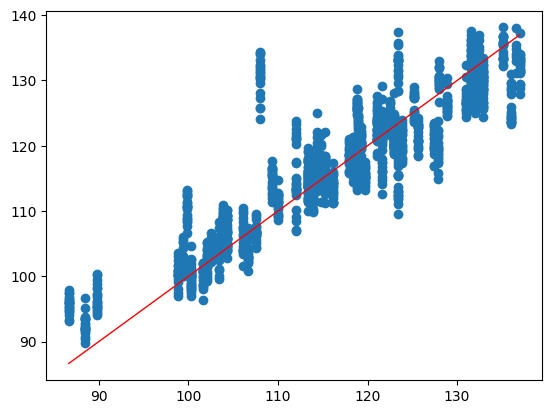

In [54]:
plt.scatter(y_test, predicted_weight)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linewidth=1) 


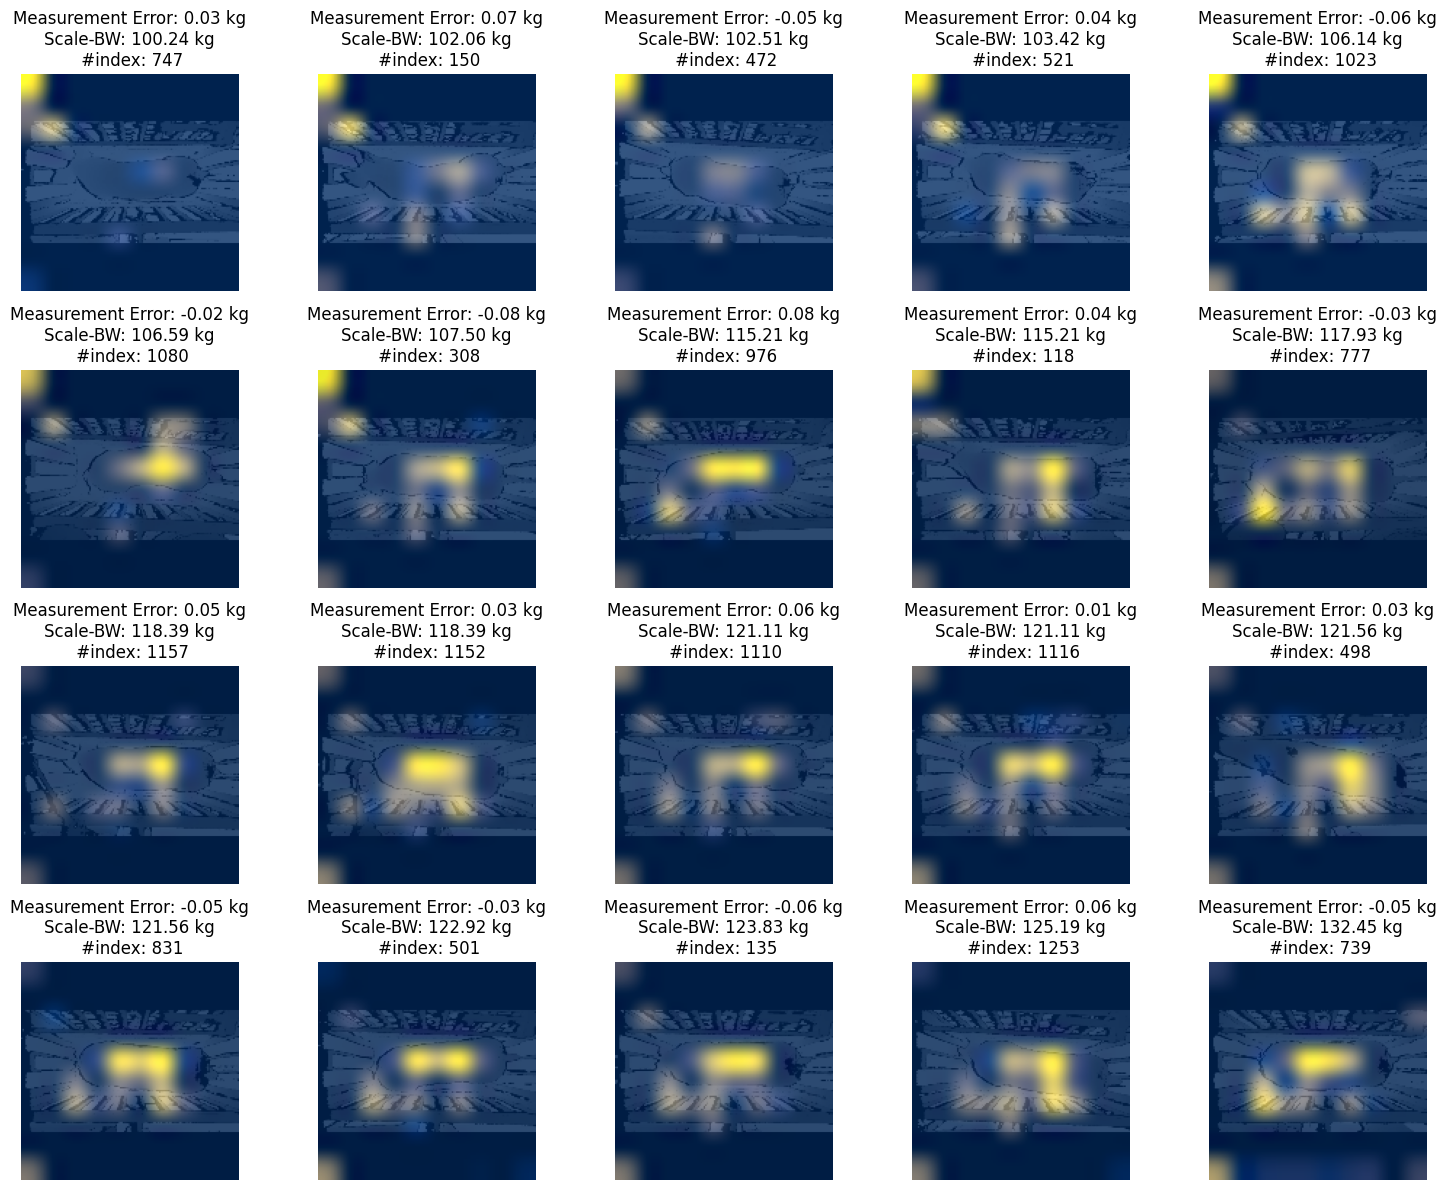

In [81]:

# Example usage
labelss = y_test-predicted_weight

img_paths = [test_img_path[i] for i in rrr]
heatmaps = [make_gradcam_heatmap(np.expand_dims(x_test[i], axis=0), model, 'stack4_block5_post_2_conv') for i in rrr]
# heatmaps = [make_gradcam_heatmap(np.expand_dims(x_test[i], axis=0), model, 'features_conv') for i in rrr]

labels = [(round(labelss[i], 2)) for i in rrr]
groud_bw = [(round(y_test[i], 2)) for i in rrr]

# Calculate grid size
num_images = len(heatmaps)
cols = 5  # Number of columns (you can adjust this)
rows = len(rrr) // cols  # Calculate number of rows needed

display_gradcam_grid(img_paths, heatmaps, labels, groud_bw, rrr, grid_size=(rows, cols))


In [ ]:
img_path = keras.utils.get_file(
    "cat_and_dog.jpg",
    "https://storage.googleapis.com/petbacker/images/blog/2017/dog-and-cat-cover.jpg",
)

display(Image(img_path))

# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Print what the two top predicted classes are
preds = model.predict(img_array)
print("Predicted:", decode_predictions(preds, top=2)[0])

In [ ]:
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=260)

save_and_display_gradcam(img_path, heatmap)

In [ ]:
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=285)

save_and_display_gradcam(img_path, heatmap)